In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib; import pylab as plt;
%matplotlib inline

In [3]:
from mpl_toolkits.basemap import Basemap

In [4]:
dims = nc.Dataset("T21.nc","r")

In [5]:
print "Code\tDimensions"
for i in dims.variables:
    print i,'\t',dims.variables[i][:].shape

Code	Dimensions
lat 	(32,)
lon 	(64,)


In [6]:
lts = dims.variables['lat'][:]
lns = dims.variables['lon'][:]
lons, lats = np.meshgrid(lns,lts)

In [7]:
print lts

[ 85.76058712  80.26877907  74.74454037  69.21297617  63.67863556
  58.14295405  52.60652603  47.06964206  41.53246125  35.99507841
  30.45755396  24.91992863  19.38223135  13.84448373   8.30670286
   2.76890301  -2.76890301  -8.30670286 -13.84448373 -19.38223135
 -24.91992863 -30.45755396 -35.99507841 -41.53246125 -47.06964206
 -52.60652603 -58.14295405 -63.67863556 -69.21297617 -74.74454037
 -80.26877907 -85.76058712]


In [8]:
print lns

[   0.       5.625   11.25    16.875   22.5     28.125   33.75    39.375
   45.      50.625   56.25    61.875   67.5     73.125   78.75    84.375
   90.      95.625  101.25   106.875  112.5    118.125  123.75   129.375
  135.     140.625  146.25   151.875  157.5    163.125  168.75   174.375
  180.     185.625  191.25   196.875  202.5    208.125  213.75   219.375
  225.     230.625  236.25   241.875  247.5    253.125  258.75   264.375
  270.     275.625  281.25   286.875  292.5    298.125  303.75   309.375
  315.     320.625  326.25   331.875  337.5    343.125  348.75   354.375]


In [9]:
darea = np.zeros((len(lts),len(lns)))
NLAT = len(lts)
lts1 = np.zeros(NLAT)
lts2 = np.zeros(NLAT)
lts1[0] = 0.5*np.pi
lts1[NLAT-1] = 0.5*(lts[NLAT-2]+lts[NLAT-1])*np.pi/180.0
lts2[0] = 0.5*(lts[0]+lts[1])*np.pi/180.0
lts2[NLAT-1] = -0.5*np.pi
for jlat in range(1,NLAT-1):
    lts1[jlat] = 0.5*(lts[jlat-1]+lts[jlat])*np.pi/180.0
    lts2[jlat] = 0.5*(lts[jlat+1]+lts[jlat])*np.pi/180.0
NLON = len(lns)
for jlat in range(0,NLAT):
    darea[jlat,:] = 0.5/NLON*(np.sin(lts1[jlat])-np.sin(lts2[jlat]))

globalarea = np.sum(darea)
print globalarea

1.0


In [10]:
def wrap2d(datd,vals):
    modf=np.zeros(datd.ndim,dtype=int)
    modf[-1]=1
    dd=np.zeros(datd.shape+modf)
    dd[:,0:datd.shape[-1]]=datd
    dd[:,datd.shape[-1]]=vals
    return dd

In [11]:
latsw=wrap2d(lats,lats[:,0])
lonsw=wrap2d(lons,360.0)

In [12]:
ncontinents = 7 #There's no guarantee you actually get this many if it's >1, since continents can merge

In [13]:
landfraction = 0.29


In [14]:
name="Example"

In [32]:
grid = np.zeros((len(lts),len(lns)))

In [33]:
landpts=[]

In [34]:
landarea = 0.0
for i in range(0,ncontinents):
    filled = False
    if landfraction<=i*np.amin(darea):
        filled=True
    while not filled:
        lt = np.random.rand()*180.0-90.0
        ln = np.random.rand()*360.0
        alts = abs(lts-lt)
        alns = abs(lns-ln)
        ilt = np.where(alts == np.amin(alts))[0][0]
        iln = np.where(alns == np.amin(alns))[0][0]
        if (ilt,iln) not in landpts:
            landpts.append((ilt,iln))
            grid[ilt,iln] = 1.0
            landarea+=darea[ilt,iln]
            filled=True

0.00274372133357 [(16, 25), (0, 32), (31, 8), (9, 29), (0, 37), (6, 55), (17, 8)]


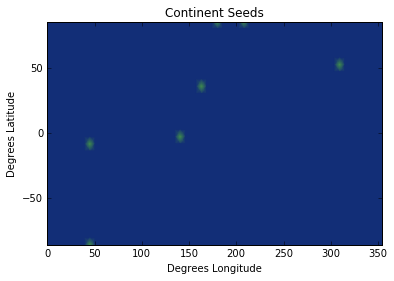

In [35]:
print landarea,landpts
plt.close('all')
t=plt.pcolormesh(lons,lats,grid,shading='Gouraud',cmap='gist_earth',vmin=-0.3,vmax=2.5)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.ylim(np.amin(lts),np.amax(lts))
plt.xlim(np.amin(lns),np.amax(lns))
plt.title("Continent Seeds")
#plt.imshow(grid,cmap='gist_earth',vmin=-0.3,vmax=2.5)

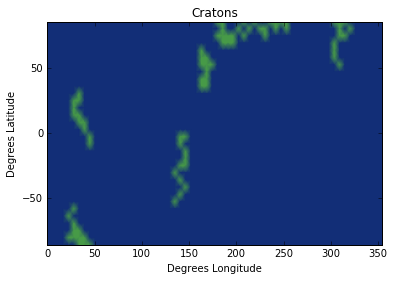

In [36]:
done=False
maxiters = int(max(5000.0/(1-landfraction+1.0e-7),5.0e4))
directions = [(1,0),(0,1),(-1,0),(0,-1),(-1,1),
              (-1,-1),(1,1),(1,-1)]
for i in range(0,len(directions)):
    directions[i] = np.array(directions[i])
iters = 0
if len(landpts)<1:
    done=True
history=[]
history.append(landarea)
nseeds=len(landpts)
if not done:
    for k in range(0,75):
        jn = k%(len(landpts)-1) #int(round(np.random.rand()*(nseeds-1)))
        accepted = False
        n=0
        while not accepted and n<len(directions):
            dn = int(round(np.random.rand()*(len(directions)-1)))
            check=False
            ct=0
            while not check:
                ckpt = list(np.array(landpts[jn])+directions[dn])
                check=True
                if ckpt[0]<0 or ckpt[0]>NLAT-1:
                    check=False
                    dn = int(round(np.random.rand()*(len(directions)-1)))
                if ckpt[1]<0:
                    ckpt[1]=NLON-1
                if ckpt[1]==NLON:
                    ckpt[1]=0
            nupt = ckpt
            if nupt not in landpts:
                accepted = True
                ilt = nupt[0]
                iln = nupt[1]
                if landarea+darea[ilt,iln]>landfraction*1.1:
                    accepted = False
                else:
                    landarea+=darea[ilt,iln]
                    grid[ilt,iln] = 1.0
                    landpts.append(nupt)
            history.append(landarea)
            n+=1

partialgrid=np.zeros(grid.shape)
partialgrid[:] = grid[:]
t=plt.pcolormesh(lons,lats,partialgrid,shading='Gouraud',cmap='gist_earth',vmin=-0.3,vmax=2.5)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.ylim(np.amin(lts),np.amax(lts))
plt.xlim(np.amin(lns),np.amax(lns))
plt.title("Cratons")
            
if landarea>landfraction:
    done=True
    
while not done:
    jn = int(round(np.random.rand()*(len(landpts)-1)))
    accepted = False
    n=0
    while not accepted and n<len(directions):
        dn = int(round(np.random.rand()*(len(directions)-1)))
        check=False
        ct=0
        while not check:
            ckpt = list(np.array(landpts[jn])+directions[dn])
            check=True
            if ckpt[0]<0 or ckpt[0]>NLAT-1:
                check=False
                dn = int(round(np.random.rand()*(len(directions)-1)))
            if ckpt[1]<0:
                ckpt[1]=NLON-1
            if ckpt[1]==NLON:
                ckpt[1]=0
        nupt = ckpt
        if nupt not in landpts:
            accepted = True
            ilt = nupt[0]
            iln = nupt[1]
            if landarea+darea[ilt,iln]>landfraction*1.1:
                accepted = False
            else:
                landarea+=darea[ilt,iln]
                grid[ilt,iln] = 1.0
                landpts.append(nupt)
        history.append(landarea)
        n+=1
    iters+=1
    if iters==maxiters or landarea>landfraction:
        done=True
        

(0.0, 354.375)

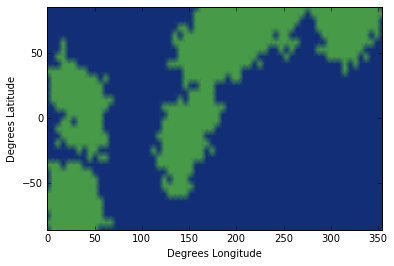

In [37]:
t=plt.pcolormesh(lons,lats,grid,shading='Gouraud',cmap='gist_earth',vmin=-0.3,vmax=2.5)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.ylim(np.amin(lts),np.amax(lts))
plt.xlim(np.amin(lns),np.amax(lns))
#plt.imshow(grid,cmap='gist_earth',vmin=-0.3,vmax=2.5)

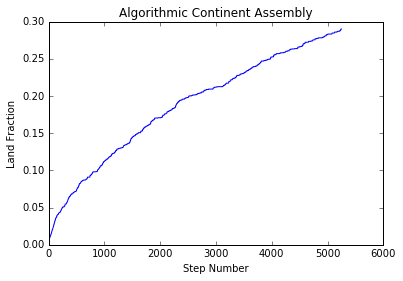

In [38]:
plt.plot(history)
plt.xlabel("Step Number")
plt.ylabel("Land Fraction")
plt.title("Algorithmic Continent Assembly")

In [39]:
print landarea

0.290085095664


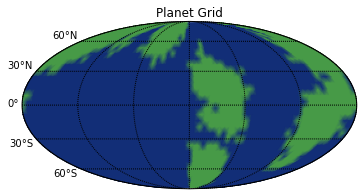

In [40]:
dataw=wrap2d(grid,grid[:,0])

m = Basemap(projection='moll',lon_0=0,resolution='c')
tm = m.pcolormesh(lonsw,latsw,dataw,shading='Gouraud',cmap='gist_earth',latlon=True,vmin=-0.3,vmax=2.5)
pr=m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,1])
mr=m.drawmeridians(np.arange(-180,180.,60.))
plt.title("Planet Grid")

In [41]:
#Topography:

topo = np.zeros(grid.shape)
topo = grid*1.0e4

maxiters = 10

dl1 = NLON/2+2
dl2 = NLON/2
dl3 = NLON/2-2

for i in range(0,maxiters):
    nutop = np.zeros(grid.shape)
    for jlat in range(0,NLAT):
        j1 = jlat-1
        j2 = jlat+1
        flip1=False
        flip2=False
        if j1<0:
            j1=0
            flip1=True
        if j2==NLAT:
            j2=NLAT-1
            flip2=True
        for jlon in range(0,NLON):
            l1 = jlon-1
            l2 = jlon+1
            if l1<0:
                l1=NLON-1
            if l2==NLON:
                l2=0
            c1 = topo[j1,(l1  +flip1*dl1)%NLON]
            c2 = topo[j1,(jlon+flip1*dl2)%NLON]
            c3 = topo[j1,(l2  +flip1*dl3)%NLON]
            c4 = topo[jlat,l1]
            c5 = topo[jlat,l2]
            c6 = topo[j2,(l1  +flip2*dl1)%NLON]
            c7 = topo[j2,(jlon+flip2*dl2)%NLON]
            c8 = topo[j2,(l2  +flip2*dl3)%NLON]
            nutop[jlat,jlon] = (2*topo[jlat,jlon]+c1+c2+c3+c4+c5+c6+c7+c8)*0.1
    topo[:] = nutop[:]
    topo*=grid

In [42]:
antigrid = -(grid-1)
topo -= 3000*antigrid
print np.amin(topo)

-3000.0


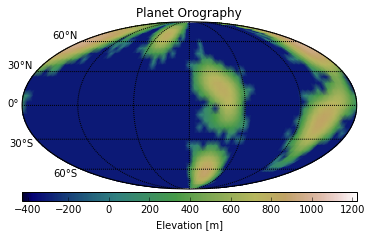

In [43]:
dataw=wrap2d(topo,topo[:,0])

m = Basemap(projection='moll',lon_0=0,resolution='c')
tm = m.pcolormesh(lonsw,latsw,dataw/9.8,shading='Gouraud',cmap='gist_earth',latlon=True,vmin=np.amin(topo/9.8)*1.4,vmax=np.amax(topo/9.8)*1.25)#,vmin=-0.1*np.amax(topo/9.8),vmax=np.amax(topo/9.8)*1.25)
pr=m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,1])
mr=m.drawmeridians(np.arange(-180,180.,60.))
cb = m.colorbar(tm,"bottom", size="5%", pad="2%",label="Elevation [m]")
plt.title("Planet Orography")
plt.savefig("sampleplanet.jpg",bbox_inches='tight')

(0.0, 354.375)

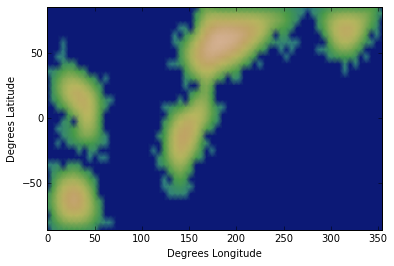

In [44]:
t=plt.pcolormesh(lons,lats,topo/9.8,shading='Gouraud',cmap='gist_earth',vmin=np.amin(topo/9.8)*1.4,vmax=np.amax(topo/9.8)*1.25)#vmin=-0.1*np.amax(topo/9.8),vmax=np.amax(topo/9.8)*1.25)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.ylim(np.amin(lts),np.amax(lts))
plt.xlim(np.amin(lns),np.amax(lns))
#plt.imshow(grid,cmap='gist_earth',vmin=-0.3,vmax=2.5)

In [45]:
topo += 3000*antigrid

In [46]:
def writeSRA(name,kcode,field,NLAT,NLON):
    label=name+'_surf_%04d.sra'%kcode
    header=[kcode,0,20170927,0,NLON,NLAT,0,0]
    fmap = field.reshape((NLAT*NLON/8,8))
    sheader = ''
    for h in header:
        sheader+=" %11d"%h
    
    lines=[]
    i=0
    while i<NLAT*NLON/8:
        l=''
        for n in fmap[i,:]:
            l+=' %9.3f'%n
        lines.append(l)
        i+=1

    text=sheader+'\n'+'\n'.join(lines)+'\n' 

    f=open(label,'w')
    f.write(text)
    f.close()
    print label

In [47]:
writeSRA(name,129,topo,NLAT,NLON)
writeSRA(name,172,grid,NLAT,NLON)

Example_surf_0129.sra
Example_surf_0172.sra
